In [1]:
# Cell 1: Install requirements and import dependencies
# Provide the path to the parent directory here
parent_dir = '/Users/moazam_a12/Skill Gap Analysis Tool'

# Install requirements
import os
requirements_path = os.path.join(parent_dir, 'requirements.txt')
os.system(f'pip install -r "{requirements_path}"')

# Import dependencies
import sys
utils_dir = os.path.join(parent_dir, 'utils')
models_dir = os.path.join(parent_dir, 'models')
for directory in [utils_dir, models_dir]:
    if directory not in sys.path:
        sys.path.append(directory)
        print(f"Added {directory} to sys.path")  # Debug print to confirm path

try:
    from preprocess import preprocess_data
    from vectorize import vectorize_skills
    from cluster import cluster_jobs
    from match import match_interns
    from gap_analysis import analyze_skill_gaps
except ImportError as e:
    print(f"Import error: {e}")
    raise

import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.decomposition import PCA
import numpy as np
import pickle

Added /Users/moazam_a12/Skill Gap Analysis Tool/utils to sys.path
Added /Users/moazam_a12/Skill Gap Analysis Tool/models to sys.path


In [3]:
# Cell 2: Preprocess datasets and showcase results
# Preprocess datasets
intern_file = os.path.join(parent_dir, 'data', 'ML_internship_Applicants.csv')
job_file = os.path.join(parent_dir, 'data', '1000_ml_jobs_us.csv')
course_file = os.path.join(parent_dir, 'data', 'Coursera.csv')
output_dir = os.path.join(parent_dir, 'utils')
intern_output, job_output, course_output = preprocess_data(intern_file, job_file, course_file, output_dir)

# Load preprocessed data
preprocessed_interns = pd.read_csv(intern_output)
preprocessed_jobs = pd.read_csv(job_output)
preprocessed_courses = pd.read_csv(course_output)

# Truncate Skills_Text for display
def truncate_skills(text, max_length=100):
    if pd.isna(text) or not isinstance(text, str):
        return ''
    if len(text) > max_length:
        return text[:max_length] + '...'
    return text

preprocessed_interns['Skills_Text_Display'] = preprocessed_interns['Skills_Text'].apply(truncate_skills)
preprocessed_jobs['Skills_Text_Display'] = preprocessed_jobs['Skills_Text'].apply(truncate_skills)
preprocessed_courses['Skills_Text_Display'] = preprocessed_courses['Skills_Text'].apply(truncate_skills)

# Display preprocessing results with elegant formatting
print(f'Preprocessed Intern Data: {preprocessed_interns.shape[0]} rows, {preprocessed_interns.shape[1]-1} columns')
print('Sample Intern Data (first 5 rows):')
print(tabulate(preprocessed_interns[['Intern ID', 'Skills_Text_Display']].head(), headers=['Intern ID', 'Skills_Text'], tablefmt='grid', stralign='left', maxcolwidths=[15, 100]))
print(f'\nPreprocessed Job Data: {preprocessed_jobs.shape[0]} rows, {preprocessed_jobs.shape[1]-1} columns')
print('Sample Job Data (first 5 rows):')
print(tabulate(preprocessed_jobs[['job_title', 'Skills_Text_Display']].head(), headers=['job_title', 'Skills_Text'], tablefmt='grid', stralign='left', maxcolwidths=[35, 100]))
print(f'\nPreprocessed Course Data: {preprocessed_courses.shape[0]} rows, {preprocessed_courses.shape[1]-1} columns')
print('Sample Course Data (first 5 rows):')
print(tabulate(preprocessed_courses[['course', 'Skills_Text_Display']].head(), headers=['course', 'Skills_Text'], tablefmt='grid', stralign='left', maxcolwidths=[35, 100]))

Preprocessed Intern Data: 1136 rows, 2 columns
Sample Intern Data (first 5 rows):
+----+-------------+---------------------------------------------------------------------------------------------------------+
|    | Intern ID   | Skills_Text                                                                                             |
+====+=============+=========================================================================================================+
|  0 | intern_0001 | deep learning, ms-excel, ms-word, mysql, python, sql, deep learning low, python low                     |
+----+-------------+---------------------------------------------------------------------------------------------------------+
|  1 | intern_0002 | adobe after effects, adobe illustrator, adobe photoshop, amazon web services (aws), angularjs, c pro... |
+----+-------------+---------------------------------------------------------------------------------------------------------+
|  2 | intern_0003 | amazon w

PCA reduced dimensions to 20 components
Elbow method results saved to /Users/moazam_a12/Skill Gap Analysis Tool/utils/elbow_results.csv
Using k=7 clusters based on elbow plot analysis.

Cluster Sizes:
Cluster 0: 81 jobs
Cluster 1: 232 jobs
Cluster 2: 146 jobs
Cluster 3: 174 jobs
Cluster 4: 91 jobs
Cluster 5: 97 jobs
Cluster 6: 176 jobs
Clustered jobs saved to /Users/moazam_a12/Skill Gap Analysis Tool/utils/clustered_jobs.csv

Job Clustering Results (k=7): 997 jobs in 7 clusters
Silhouette Score: 0.126 (higher is better, >0.5 is good)
Davies-Bouldin Index: 2.207 (lower is better, <1 is good)
Sample Clustered Jobs (first 5 rows):
+----+-------------------------------------------------------+---------------+-----------+-------------------------------------------------+
|    | job_title                                             | Skills_Text   |   Cluster | Role                                            |
+====+=======================================================+===============+====

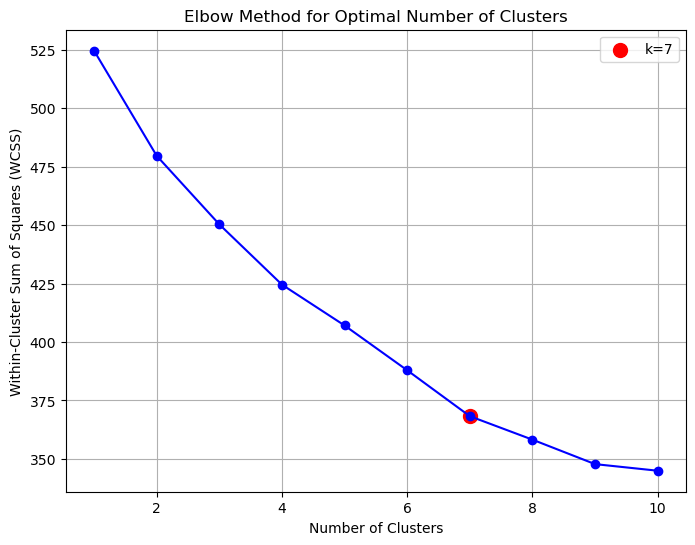

In [5]:
# Cell 3: TF-IDF Vectorization, K-Means Clustering, and Matching
# Vectorize skills
intern_tfidf, job_tfidf, course_tfidf, feature_names = vectorize_skills(preprocessed_interns, preprocessed_jobs, preprocessed_courses)

# Cluster jobs with optimized parameters
num_clusters = 7  # Reverted to 7 for better results
n_components = 20  # Match your current setting
job_df, centroids, cluster_names, silhouette, db_index, pca = cluster_jobs(job_tfidf, preprocessed_jobs, feature_names, output_dir, num_clusters=num_clusters, n_components=n_components)

# Save PCA model for consistent transformations
pca_output = os.path.join(output_dir, 'pca_model.pkl')
with open(pca_output, 'wb') as f:
    pickle.dump(pca, f)

# Display clustering results
print(f'\nJob Clustering Results (k={num_clusters}): {job_df.shape[0]} jobs in {len(cluster_names)} clusters')
if silhouette is not None:
    print(f'Silhouette Score: {silhouette:.3f} (higher is better, >0.5 is good)')
    print(f'Davies-Bouldin Index: {db_index:.3f} (lower is better, <1 is good)')
print('Sample Clustered Jobs (first 5 rows):')
print(tabulate(job_df[['job_title', 'Skills_Text_Display', 'Cluster', 'Role']].head(), 
               headers=['job_title', 'Skills_Text', 'Cluster', 'Role'], 
               tablefmt='grid', stralign='left', maxcolwidths=[35, 100, 10, 50]))

# Perform intern matching (jobs and courses)
intern_matches = match_interns(intern_tfidf, centroids, course_tfidf, preprocessed_interns, preprocessed_courses, feature_names, job_tfidf, cluster_names, output_dir, pca)

# Plot elbow curve
elbow_data = pd.read_csv(os.path.join(output_dir, 'elbow_results.csv'))
plt.figure(figsize=(8, 6))
plt.plot(elbow_data['Clusters'], elbow_data['WCSS'], marker='o', linestyle='-', color='b')
plt.scatter(num_clusters, elbow_data[elbow_data['Clusters'] == num_clusters]['WCSS'], color='red', s=100, label=f'k={num_clusters}')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Cell 4: Skill Gap Analysis and Course Recommendations
# Set the number of interns to display
num_rows = 1  # Change this to display a different number of rows (e.g., 10, 20, or 0 for all)
# Perform skill gap analysis
gap_results = analyze_skill_gaps(intern_matches, preprocessed_interns, job_df, preprocessed_courses, feature_names, job_tfidf, output_dir, num_rows)